# Analisis de Serie temporal

In [65]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
df = pd.read_csv('AirPassengers.csv')

df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Visualizo la Serie temporal

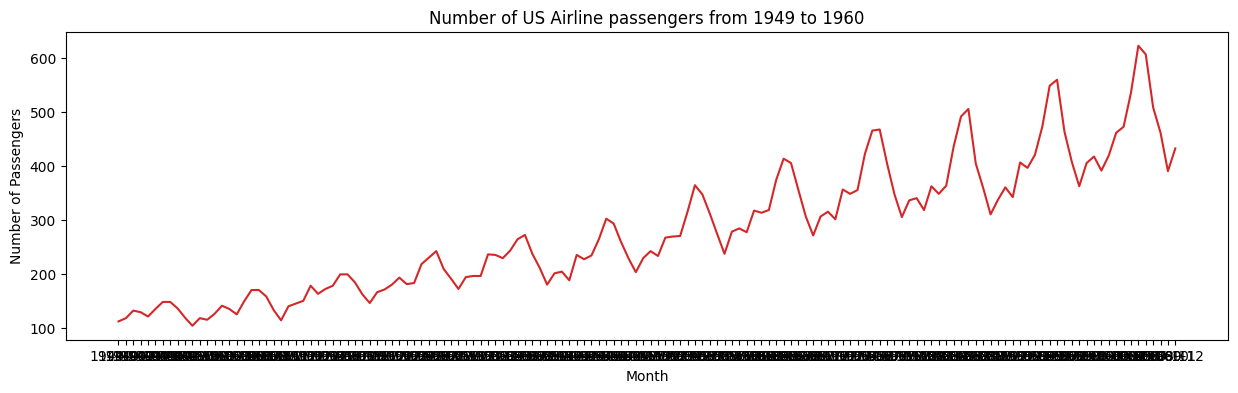

In [69]:
def plot_df(df, x, y, title="", xlabel='Month', ylabel='Number of Passengers', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()


plot_df(df, x=df['Month'], y=df['#Passengers'], title='Number of US Airline passengers from 1949 to 1960')

Se puede observar que es una serie temporal mensual y sigue un cierto patrón repetitivo cada año. Observamos que hay una clara tendencia creciente (no estacionariedad en la media) y la variación de las fluctuaciones también aumenta con el tiempo (no estacionariedad en la varianza).

# **Descomposición de una serie temporal**

## **Aditiva:**
Value = Base Level + Trend + Seasonality + Error

## **Multiplicativa:**
Value = Base Level x Trend x Seasonality x Error

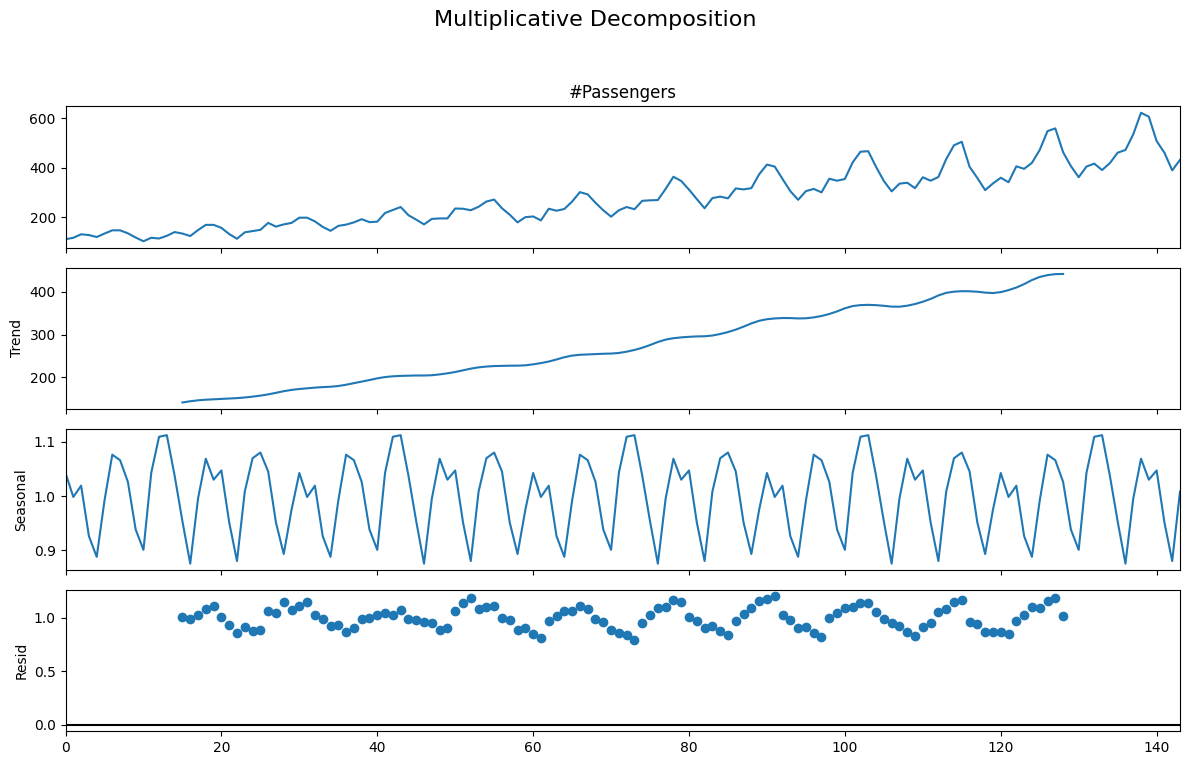

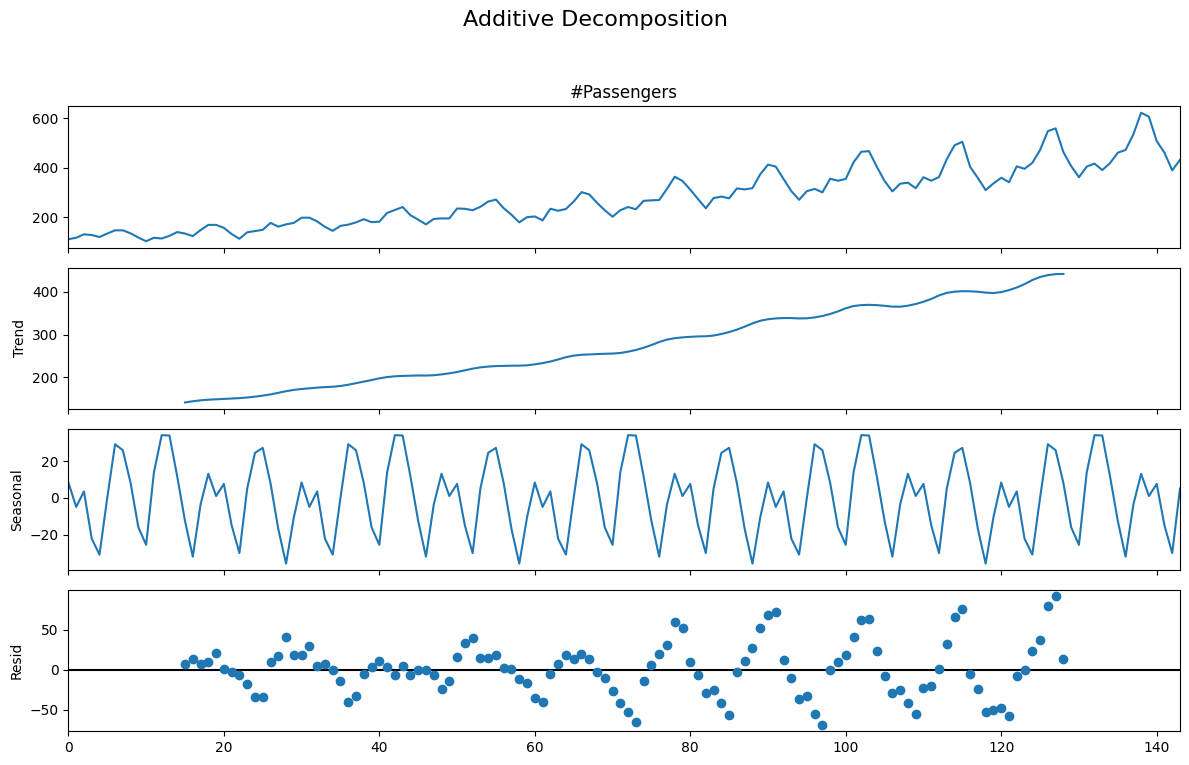

In [71]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


# Multiplicative Decomposition
multiplicative_decomposition = seasonal_decompose(df['#Passengers'], model='multiplicative', period=30)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df['#Passengers'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (12,8)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Los residuos de la descomposición aditiva parecen tener un patrón, mientras que los de la descomposición multiplicativa parecen ser mas aleatorios. Es por esta razón que para esta serie temporal sería mejor usar la descomposición multiplicativa

# **Estacionariedad**
Esta propiedad se da cuando los valores son independientes del tiempo. Para una serie estacionaria, las propiedades como la media, varianza y autocorrelación son constantes en el tiempo. La autocorrelación de la serie muestra la correlación de la serie con los valores pasados.

Es el primer paso a resolver ya que nos permite remover la correlación entre la variable predictora o explicativa

Un proceso puede ser no estacionario en la media, en la varianza, en las auto-correlaciones o en otras características de la distribución de las variables.
Cuando el nivel de la serie no es estable en el tiempo, pudiendo en particular tener tendencia creciente o decreciente, la serie es no estacionaria en la media.
Cuando la variabilidad o las autocorrelaciones se modifican con el tiempo, la serie es no estacionaria en la varianza o en las autocorrelaciones.
Finalmente, si la distribución de la variable en cada instante varía con el tiempo, la serie no es estacionaria en distribución.

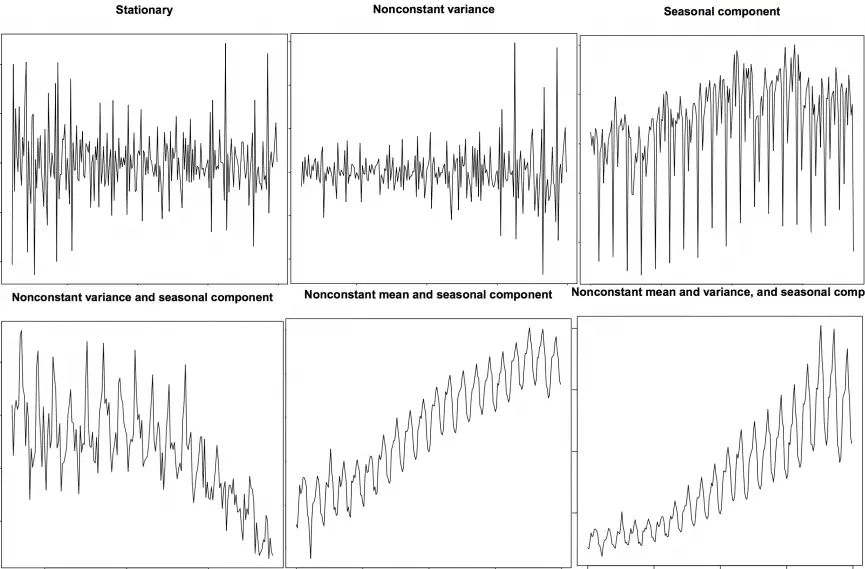

## No estacionariedad en la varianza

Si los datos muestran diferentes variaciones en diferentes niveles de la serie, entonces una transformación para estabilizar la varianza puede ser bastante útil. Para ello, existen varios métodos como aplicar el logaritmo o la transformación de Box-Cox

###Transformación de Box-Cox

Box-Cox transforma datos no normales en datos similares a la distribución normal.

¿Por qué necesitamos que nuestros datos de series temporales se parezcan a una distribución normal? Bueno, al ajustar ciertos modelos, como ARIMA, utilizan la estimación de máxima verosimilitud (MLE) para determinar sus parámetros. MLE, por definición, debe ajustarse a una determinada distribución, que para la mayoría de los paquetes es la distribución normal.

La transformación Box-Cox está parametrizada por λ (que toma valores reales de -5 a 5) y transforma la serie temporal, "y" positiva, como:

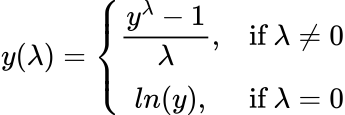


El valor λ se elige viendo qué valor se aproxima mejor a los datos transformados a la distribución normal.

In [8]:
import plotly.express as px
from scipy.stats import boxcox

data = pd.read_csv('AirPassengers.csv')

def plotting(title, data, x, y, x_label, y_label):
    """General function to plot the passenger data."""
    fig = px.line(data, x=data[x], y=data[y], labels={x: x_label, y: y_label})

    fig.update_layout(template="simple_white", font=dict(size=18),
                      title_text=title, width=650,
                      title_x=0.5, height=400)

    fig.show()

# Plot the airline passenger data
plotting(title='Airline Passengers', data=data, x='Month',
         y='#Passengers', x_label='Date', y_label='Passengers')

In [74]:
# Apply box-cox transform and plot it
data['Passengers_box_cox'], lam = boxcox(data['#Passengers'])

plotting(title=f'Airline Passengers (Box-Cox Transform, λ={lam:.2f})', data=data, x='Month', y='Passengers_box_cox',
         x_label='Date', y_label='Passengers<br>Box-Cox Transform')

Nuestra varianza ahora es estable y las fluctuaciones están en un nivel constante.

## No estacionariedad en la media

Para resolver la no estacionariedad en la media se diferencia la serie

\begin{equation}
Z_t = \nabla Y_t = Y_t - Y_{t-1}
\end{equation}

La cantidad de veces que se diferencia la serie define el orden de integración
\begin{equation}
Z_t = \nabla^n Y_t
\end{equation}
\begin{equation}
Y_t:I(n)
\end{equation}

In [10]:
# Take the difference and log and plot it
data['Passengers_Diff_box_cox'] = data['Passengers_box_cox'].diff()

plotting(title='Airline Passengers', data=data, x='Month',
         y='Passengers_Diff_box_cox', x_label='Date', y_label='Passenger<br>Box Cox and Difference')

Si hubiesemos aplicado el logaritmo en lugar de la transformación de Box-Cox:

In [11]:
data["Passenger_Log"] = np.log(data["#Passengers"])

plotting(title='Airline Passengers', data=data, x='Month',
         y='Passenger_Log', x_label='Date', y_label='Passenger<br>Log Transform')

Diferenciando nuevamente para sacar la tendencia:

In [12]:
# Take the difference and log and plot it
data["Passenger_Diff_Log"] = data["Passenger_Log"].diff()

plotting(title='Airline Passengers', data=data, x='Month',
         y='Passenger_Diff_Log', x_label='Date', y_label='Passenger<br>Log and Difference')

Utilizando la transformacion del logaritmo se observa una menor varianza que con la transformación de Box-Cox

# **Test de Estacionariedad**

Sea
\begin{equation}
\{Y_t\} : ARMA(p, q)
\end{equation}
un proceso estocástico donde
\begin{equation}
 \{\epsilon_t\} : WN \sim N(0, \sigma_{\epsilon})
\end{equation}
\begin{equation}
Y_t = \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \ldots + \phi_p Y_{t-p} + \epsilon_t - \theta_1 \epsilon_{t-1} - \theta_2 \epsilon_{t-2} - \ldots - \theta_q \epsilon_{t-q}
\end{equation}
\begin{equation}
(1 - \phi_1 B - \phi_2 B^2 - \ldots - \phi_p B^p) Y_t = (1 - \theta_1 B - \theta_2 B^2 - \ldots - \theta_q B^q) \epsilon_t
\end{equation}
\begin{equation}
\Phi(B) Y_t = \Theta(B) \epsilon_t
\end{equation}
La ecuación $\Phi(B) Y_t = 0$ produce $p$ raíces $G_i \quad (i = 1, 2, \ldots, p)$.

**Condición de estacionariedad:** $\left| G_i \right| > 1 \; \text{ó} \; \left| G_i^{-1} \right| < 1$

Es decir, que las $p$ raíces sean todas, en módulo, mayores que 1.

El problema es que se decide con información muestral, es decir se poseen raíces estimadas $\hat{G}_i \; (i = 1, 2, \ldots, p)$.

Por lo tanto se utiliza una Prueba de Hipótesis para poner a prueba la conjetura de que las raíces del Polinomio Característico son iguales a la unidad. Este Test de Hipótesis se construye para no rechazar la Hipótesis Nula, a diferencia de la construcción de la mayoría de los tests.

## Test de Dickey-Fuller Aumentado (ADF)

Es el test generalmente utilizado para testear la estacionariedad de la serie. También se lo llama test de **Raíces Unitarias**. Al diferenciar la serie $AR(p)$ se obtiene la Ecuación de Dickey Fuller Aumentada:

\begin{equation}
\nabla Y_t = a_0 + a_1 t + (\phi_1^* - 1)Y_{t-1} - \sum_{j=1}^{p-1} \phi_{j+1}^* \nabla Y_{t-j} + \epsilon_t
\end{equation}
donde
\begin{equation}
\phi_n^*=\sum_{i=n}^{p}\phi_i
\end{equation}

Esta ecuación podrá tener como máximo $p$ raíces. Para eso habrá que realizar una secuencia de prueba de hipótesis para determinar en forma secuencial la cantidad de raíces unitarias que posee la serie bajo análisis. Suponga que se quiere testear la presencia de 2 raíces unitarias. Se parte del orden mayor que se desea poner a prueba, es decir:


*   Se testea la presencia de $2$ raíces unitarias.
*   Si se rechaza la hipótesis nula del test inicial, se procede a testear la presencia de $1$ raíz unitaria. Si rechazan todos los test, se afirma que bajo la evidencia empírica, la serie es estacionaria. Si no rechaza dicho test, se afirma que bajo la evidencia empírica, la serie presenta una raíz unitaria y se procede a diferenciar una vez para convertirla en estacionaria.
*   Si no rechaza la hipótesis nula del test inicial, bajo la evidencia empírica se afirma que la serie posee $2$ raíces unitarias y se procede a diferenciar dos veces para convertirla en estacionaria.

### Test para $2$ raíces unitarias

La ecuación de DF es la siguiente

\begin{equation}
\nabla^2 Y_t = (\phi_1^{**} - 1) \nabla Y_{t-1} - \sum_{j=1}^{p-1} \phi_{j+1}^{**} \nabla^2 Y_{t-j} + \epsilon_t
\end{equation}

Las hipótesis son
\begin{equation}
\begin{aligned}
H_0 &: \phi_1^{**} - 1 = 0 &\quad I(2) \\
H_1 &: \phi_1^{**} - 1 < 0 &\quad I(1)\quad \text{ó} \quad I(0) \\
\end{aligned}
\end{equation}

Se plantea que

\begin{equation}
\tau^e = \frac{\hat{\phi}_1 - \phi_1}{\sigma(\hat{\phi}_1)} \to \frac{\int_0^1 B(t) \, dt}{\sqrt{\int_0^1 [B(t)]^2 \, dt}}
\end{equation}

Donde $B (t)$ es un Proceso Estocástico Continuo-Continuo (Tiempo-Variables) denominado **Movimiento Browniano** (Brownian Motion)

Por lo que el estadístico a utilizar es

\begin{equation}
\tau^e = \frac{\phi^{**}_1 - 1}{\sigma(\phi^{**}_1)}
\end{equation}

La regla de decisión es
\begin{equation}
\text{Si } \tau^e < \tau \implies \text{Rechazo } H_0
\end{equation}

Si se rechaza la hipótesis nula se procede a realizar el siguiente test para poner a prueba la conjetura de 1 raíz unitaria. En caso de no rechazar la raíz unitaria, se debe diferenciar dos veces para convertirla en estacionaria.

### Test para $1$ raíz unitaria

La ecuación de DF es la siguiente

\begin{equation}
\nabla Y_t = (\phi_1^* - 1) Y_{t-1} - \sum_{j=1}^{p-1} \phi_{j+1}^* \nabla Y_{t-j} + \epsilon_t
\end{equation}

Las hipótesis son
\begin{equation}
\begin{aligned}
H_0 &: \phi_1^{*} - 1 = 0 &\quad I(1) \\
H_1 &: \phi_1^{*} - 1 < 0 &\quad I(0) \\
\end{aligned}
\end{equation}

El estadístico a utilizar es

\begin{equation}
\tau^e = \frac{\phi^{*}_1 - 1}{\sigma(\phi^{*}_1)}
\end{equation}

La regla de decisión es
\begin{equation}
\text{Si } \tau^e < \tau \implies \text{Rechazo } H_0
\end{equation}

Si se rechaza la hipótesis nula se procede a determinar que la serie es estacionaria bajo la evidencia empírica. En caso de no rechazar la raíz unitaria, se debe diferenciar una vez para convertirla en estacionaria.

### Generalización del test

Para generalizar este procedimiento, se trata de encontrar el valor de $p$ óptimo que mejor se ajuste a la serie (determinado por Criterios de Información). El procedimiento es el siguiente:

*   Se plantea un valor elevado de $p$ y se procede a estimar la serie partiendo del orden más elevado hasta encontrar aquella representación con el menor valor de Criterio de Información (AIC, SBC, etc).
*   Cuando se encuentra dicho valor de $p$ se selecciona como el valor óptimo de la serie y luego se procede a realizar el test considerando dicho valor partiendo de diferenciar la serie $p$ veces.



In [21]:
from statsmodels.tsa.stattools import adfuller


def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    #El criterio de información puede ser AIC O BIC
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

'''
Algunos parametros de la funcion adfuller:

x: The data series to test.

maxlag: Maximum lag which is included in test

regression: {“c”,”ct”,”ctt”,”n”} Constant and trend order to include in regression.
“c” : constant only (default).
“ct” : constant and trend.
“ctt” : constant, and linear and quadratic trend.
“n” : no constant, no trend.

autolag{“AIC”, “BIC”, “t-stat”, None} Method to use when automatically determining the lag length among the values 0, 1, …, maxlag.
'''

adf_test(data["Passenger_Diff_Log"][1:])

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


En este caso, como el p-value arrojado por el test es mayor a un nivel de significación del 5%, entonces no se rechaza la hipotesis nula. La serie no es estacionaria

\begin{equation}
\text{Si } p-value < \alpha \implies \text{Rechazo } H_0
\end{equation}

## Test KPSS
El test KPSS se utiliza para probar una hipótesis nula de que una serie temporal observable es estacionaria alrededor de una tendencia determinista (es decir , estacionaria de tendencia ) frente a la alternativa de una raíz unitaria. Contrariamente a la mayoría de las pruebas de raíz unitaria , la presencia de una raíz unitaria no es la hipótesis nula sino la alternativa. Además, en la prueba KPSS, la ausencia de una raíz unitaria no es una prueba de estacionariedad sino de tendencia-estacionariedad.
Esta es una distinción importante ya que es posible que una serie de tiempo sea no estacionaria, no tenga una raíz unitaria y sea estacionaria de tendencia.

En presencia de un choque, los procesos estacionarios de tendencia son reversos a la media (es decir, transitorios, las series de tiempo convergerán nuevamente hacia la media creciente, que no se vio afectada por el choque)

In [22]:
from statsmodels.tsa.stattools import kpss


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


'''
Algunos parametros de la funcion kpss:

x: The data series to test.

regressionstr{“c”, “ct”}
The null hypothesis for the KPSS test.
“c” : The data is stationary around a constant (default).
“ct” : The data is stationary around a trend.
'''

kpss_test(data["Passenger_Diff_Log"][1:])

Results of KPSS Test:
Test Statistic           0.038304
p-value                  0.100000
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


<ipython-input-22-f50aa50af3f2>:6: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




El p-value arrojado por el test es mayor a un nivel de significación del 5%, entonces no se rechaza la hipotesis nula. La serie es estacionaria de tendencia